-----

# Simple Loggerについて

-----

ogawa 2019.1.19



## Logger Module の狙い

***
### ターゲット
- 柔軟に設計したいユーザー
- シンプルに設計したいユーザー

### 柔軟に設計したいユーザーへのコンセプト
- ロギングのタイミングを自由に
- ロギングしたい変数選択を自由に
- ロギング量を自由に

### シンプルに設計したいユーザーへのコンセプト
- 引数をできるだけ最小限に

イメージ：用途に応じて　functional と sequential と同様の方法で実装してもらう
***

# ノートの狙い

<hr>

Simple Logger モジュールの理解、およびテスト

## ライブラリ
------
- ReNomRL v0.4
- tqdm 4.19.9
- numpy 1.14.0

# アルゴリズム定義
<hr>

DQNと仮定する

In [1]:
from time import sleep
import numpy as np


def try_except(self,func):
    def inner(*args,**kwargs):
        try:
            func(*args,**kwargs)
        finally:
            self.logger.close()
    return inner


def remove_col(self,func):
    def inner(*args,**kwargs):
        return func(*args,**kwargs)[:-2]
    return inner




class DQN(object):
    def __init__(self,logger):
        logger._key_check(["state","reward","terminal"])
        self.logger = logger
        self.fit = try_except(self,self.fit)
    
    
    def fit(self):
        self.logger.start(30)

        s,r=0,0
        for i in range(30):
            s += 1
            sleep(0.1)
            r += np.array([np.random.randint(-2,3),np.random.randint(0,6)])
            t = np.random.randint(0,2)
            self.logger.logger(state=s,reward=r,terminal=t)
            self.logger.update(1)

        self.logger.close()

# Basicテスト
<hr>

## インスタンス

In [2]:
from renom_rl.utility.logger import SimpleLogger
simpleLogger = SimpleLogger(log_key = ["state","reward"] , msg="This is {} reward:{}",record_episode_base=True)

## 実行

In [3]:
dqn=DQN(simpleLogger)
dqn.fit()

This is 30 reward:[20 79]: 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]


## グラフ

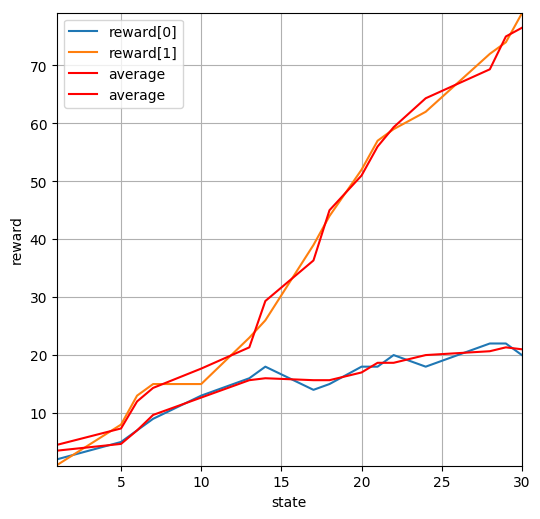

In [4]:
simpleLogger.graph(x_key="state",y_key="reward",
             figsize=(6,6),dpi=100,average_range=1)

## CSV書込

In [5]:
simpleLogger.to_csv("./test_csv.csv",overwrite=True)

## リセット

In [6]:
simpleLogger.reset()
simpleLogger.result()

{'reward': [], 'state': []}

## 読込

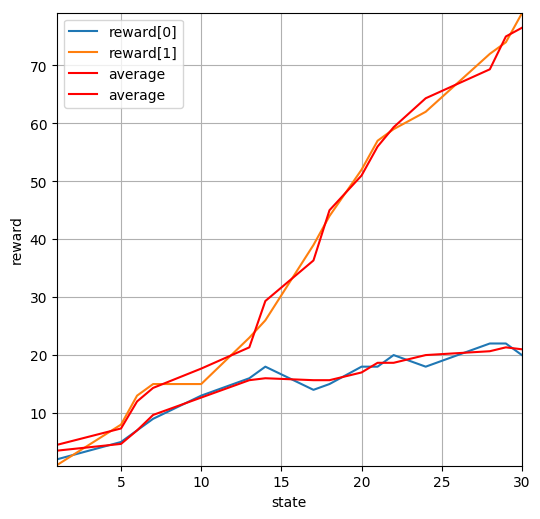

In [7]:
simpleLogger.reset()
simpleLogger.from_csv("./test_csv.csv")
simpleLogger.graph(x_key="state",y_key="reward",figsize=(6,6), dpi=100,average_range=1)

# カスタムテスト
<hr>

## show_bar=false

In [8]:
logger = SimpleLogger(log_key = ["state","reward"] , msg="This is {} reward:{}",show_bar=False)
dqn=DQN(logger)
dqn.fit()

-This is 30 reward:[-2 75]


## disable=True

In [9]:
logger = SimpleLogger(log_key = ["state","reward"] , msg="This is {} reward:{}",disable=True)
dqn=DQN(logger)
dqn.fit()

## log_key error

In [10]:
try:
    logger = SimpleLogger(log_key = ["stat","reward"] , msg="This is {} reward:{}")
    dqn=DQN(logger)
    dqn.fit()
except Exception as e:
    print(e)

stat does not exist as logging key in this module. Reset log_key.


In [11]:
logger = SimpleLogger(log_key = ["state","reward"] , msg="This is {} reward:{}")
dqn=DQN(logger)
dqn.fit()

This is 30 reward:[-5 62]: 100%|██████████| 30/30 [00:03<00:00,  9.35it/s]  


# その他
<hr>

## 1. tqdm を継承ではなくインスタンスを作成したことについて

当初　Loggerは tqdm を継承していた。   
しかし、error が生じると、複数回のエラーが生じてしまう。   
また再度、定義して実行すると、self.posがないというエラーが生じ、再定義してもうまくいかない。   
そのため、tqdmのインスタンスをクラス内で作成することにした。   

## 2. super継承していない場合のワーニングの実装方法について

metaclass　で実行することで解決。

```
class Meta(type):
    def __call__(cls, *args, **kwargs):
        self = cls.__new__(cls, *args, **kwargs)
        cls.__init__(self, *args, **kwargs)
        self._assert_logger_super()
        return self
```

## 3. 人工的デコレータについて
デコレータのある関数を書き換えると、デコレータの機能が消える。

対策案として、

- metaclass で 上書きする。setattr(self,"func",decorating_func(self.func))
- `__init__`　時に関数を上書きする。self.func = func2(self.func)

今回は後者を採用。